### Probabilistic PCA: Try till you succeed!

In this notebook, we will be coding coding Probabilistic PCA. We will work through a model, fail many times, debug our way out and refine our understanding of Pyro.


We borrow heavily from the [Prob. PCA tutorial in TFP](https://www.tensorflow.org/probability/examples/Probabilistic_PCA).


We first discuss the generative process.

Data set $\mathbf{X}=\left\{\mathbf{x}_{n}\right\}$ of $N$ data points, where each data point is $D$-dimensional,
$\mathbf{x}_{n} \in \mathbb{R}^{D}$

Aim: Represent $\mathbf{x}_{n}$ under a latent variable $\mathbf{z}_{n} \in \mathbb{R}^{K}$ with lower dimension,
$K<D$. 

Principal axes $\mathbf{W}$ relates the latent variables to the data.

Specifically, we assume that each latent variable is normally distributed,
$$
\mathbf{z}_{n} \sim N(\mathbf{0}, \mathbf{I})
$$
The corresponding data point is generated via a projection,
$$
\mathbf{x}_{n} \mid \mathbf{z}_{n} \sim N\left(\mathbf{W} \mathbf{z}_{n}, \sigma^{2} \mathbf{I}\right)
$$
where the matrix $\mathbf{W} \in \mathbb{R}^{D \times K}$ are known as the principal axes. In probabilistic $\mathrm{PCA}$, we are typically interested in estimating the principal axes $\mathbf{W}$ and the noise term $\sigma^{2}$.


In [1]:
import pyro
import torch
import matplotlib.pyplot as plt

In [2]:
dist = pyro.distributions

### Create dataset using the generative process

Text(0.5, 0, '$z_n$')

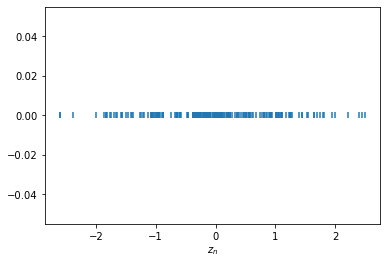

In [3]:
# First generate Z
z = dist.Normal(loc = 0., scale = 1).sample([200, 1])
plt.scatter( z.numpy(), torch.zeros(200), marker='|')
plt.xlabel(r"$z_n$")

In [4]:
# Our principal axis
W = torch.tensor([[1., 2.]])

In [6]:
z.shape, W.shape

(torch.Size([200, 1]), torch.Size([1, 2]))

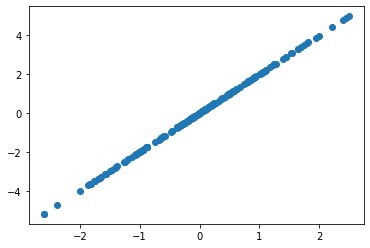

In [7]:
# Noisefree samples
zW = z@W
plt.scatter(zW[:, 0], zW[:, 1])

In [8]:
# Let us now add some noise.
X = zW_noise = zW + torch.randn_like(zW)

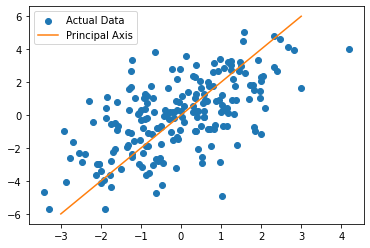

In [142]:
plt.scatter(X[:, 0], X[:, 1], label='Actual Data')
z_lin = torch.linspace(-3., 3., 200).reshape(-1, 1)
z_lin_w = z_lin@W
plt.plot(z_lin_w[:, 0], z_lin_w[:, 1], label='Principal Axis', color='C1')
plt.legend()

### Without plate notation

We will mainly try to reconstruct 

$X \sim \mathcal{N}(ZW, 1)$ where

$ X \in R^{N \times D} $

$W \in R^{d \times D}$

$Z \in R^{N \times d}$

For our example 

D = 2
d = 1
N = 200

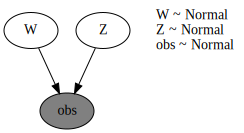

In [10]:
pyro.clear_param_store()


def ppca_model_without_plate(data, latent_dim):
    N, data_dim = data.shape
    W = pyro.sample(
        "W",
        dist.Normal(
            loc=torch.zeros([latent_dim, data_dim]),
            scale=5.0 * torch.ones([latent_dim, data_dim]),
        ),
    )
    Z = pyro.sample(
        "Z",
        dist.Normal(
            loc=torch.zeros([N, latent_dim]),
            scale=torch.ones([N, latent_dim]),
        ),
    )

    mean = Z @ W

    ob = pyro.distributions.Normal(mean, 1.0)
    return pyro.sample("obs", ob, obs=data)


pyro.render_model(
    ppca_model_without_plate, model_args=(X, 1), render_distributions=True
)

In [26]:
import logging


def create_guide_optimize_plot(model):
    pyro.clear_param_store()
    try:

        auto_guide = pyro.infer.autoguide.AutoNormal(model)
        adam = pyro.optim.Adam({"lr": 0.02})
        elbo = pyro.infer.Trace_ELBO()
        svi = pyro.infer.SVI(model, auto_guide, adam, elbo)

        losses = []
        for step in range(1000):  # Consider running for more steps.
            loss = svi.step(X, 1)
            losses.append(loss)
            if step % 100 == 0:
                logging.info("Elbo loss: {}".format(loss))

        plt.figure(figsize=(5, 2))
        plt.plot(losses)
        plt.xlabel("SVI step")
        plt.ylabel("ELBO loss")
    except Exception as e:
        print("*"*20+" Error "+"*"*20+"\n")
        print(e)
        print("\n"+"*"*48)
        return auto_guide
    return auto_guide

In [27]:
ag = create_guide_optimize_plot(ppca_model_without_plate)

******************** Error ********************

at site "W", invalid log_prob shape
  Expected [], actual [1, 2]
  Try one of the following fixes:
  - enclose the batched tensor in a with pyro.plate(...): context
  - .to_event(...) the distribution being sampled
  - .permute() data dimensions

************************************************


#### Examining Error in Model 1

Let us examine the shapes first. 

In [28]:
import pyro.poutine as poutine

trace = poutine.trace(ppca_model_without_plate).get_trace(X, 1)
trace.compute_log_prob()
print(trace.format_shapes())

Trace Shapes:        
 Param Sites:        
Sample Sites:        
       W dist   1 2 |
        value   1 2 |
     log_prob   1 2 |
       Z dist 200 1 |
        value 200 1 |
     log_prob 200 1 |
     obs dist 200 2 |
        value 200 2 |
     log_prob 200 2 |


Let us first try without the `model()` context and see what the distribution shape means.

In [29]:
latent_dim = 1
data_dim = 2

dist_W = dist.Normal(
    loc=torch.zeros([latent_dim, data_dim]),
    scale=5.0 * torch.ones([latent_dim, data_dim]),
)

dist_W.batch_shape, dist_W.event_shape, dist_W.sample().shape

(torch.Size([1, 2]), torch.Size([]), torch.Size([1, 2]))

Based on the above sizes, we can think of dist_W as a 1 X 2 table where each entry is an indepedent univariate Gaussian. Let us now try and evaluate the `log_prob` of seeing some samples from our distribution.

In [30]:
dist_W_logprob = dist_W.log_prob(dist_W.sample([5]))
dist_W_logprob.shape

torch.Size([5, 1, 2])

The above shows our problem! Think of how we may do Bayesian inference. We have a prior over W and we observe some data. We would like the posterior over W given the data. 

In the above dist_W we have a batch shape of 1,2. When we evaluate the log_prob of 5 samples, we get a (5, 1, 2) shaped array. Rather, we would want a 5-dimensional vector showing the log_prob of each of the sample. 

To evaluate different Ws, we need the logprob of the different Ws under our prior and likelihood. Thus, we need to convert our dist_W to a distribution where each draw is from a 1X2 dimensional distribution, rather than a draw from 1 X 2 normal distributions. 


<p style="background-color:Tomato;">Would be useful to get feedback and clarity on this. Still not very clear about the shapes and the logic.
</p>

In [31]:
dist_W_event = dist_W.to_event()
dist_W_event.batch_shape, dist_W_event.event_shape, dist_W_event.sample([5]).shape

(torch.Size([]), torch.Size([1, 2]), torch.Size([5, 1, 2]))

In [33]:
dist_W_event.log_prob(dist_W_event.sample([5])).shape

torch.Size([5])

Let us now change the W to to_event and create our second model and check if it works.

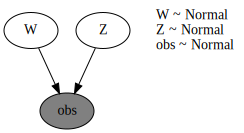

In [34]:
pyro.clear_param_store()


def ppca_model_without_plate_2(data, latent_dim):
    N, data_dim = data.shape
    W = pyro.sample(
        "W",
        dist.Normal(
            loc=torch.zeros([latent_dim, data_dim]),
            scale=5.0 * torch.ones([latent_dim, data_dim]),
        ).to_event(),
    )
    Z = pyro.sample(
        "Z",
        dist.Normal(
            loc=torch.zeros([N, latent_dim]),
            scale=torch.ones([N, latent_dim]),
        ),
    )

    mean = Z @ W

    ob = pyro.distributions.Normal(mean, 1.0)
    return pyro.sample("obs", ob, obs=data)


pyro.render_model(
    ppca_model_without_plate_2, model_args=(X, 1), render_distributions=True
)

In [35]:
ag = create_guide_optimize_plot(ppca_model_without_plate_2)

******************** Error ********************

at site "Z", invalid log_prob shape
  Expected [], actual [200, 1]
  Try one of the following fixes:
  - enclose the batched tensor in a with pyro.plate(...): context
  - .to_event(...) the distribution being sampled
  - .permute() data dimensions

************************************************


In [36]:
trace = poutine.trace(ppca_model_without_plate_2).get_trace(X, 1)
trace.compute_log_prob()
print(trace.format_shapes())

Trace Shapes:            
 Param Sites:            
Sample Sites:            
       W dist       | 1 2
        value       | 1 2
     log_prob       |    
       Z dist 200 1 |    
        value 200 1 |    
     log_prob 200 1 |    
     obs dist 200 2 |    
        value 200 2 |    
     log_prob 200 2 |    


Let us similarly try and understand the role of Z

In [37]:
N = 200
latent_dim = 1
Z_dist = dist.Normal(
            loc=torch.zeros([N, latent_dim]),
            scale=torch.ones([N, latent_dim]),
        )

Z_dist.batch_shape, Z_dist.event_shape

(torch.Size([200, 1]), torch.Size([]))

In [38]:
Z_dist.log_prob(Z_dist.sample([5])).shape

torch.Size([5, 200, 1])

In [39]:
Z_dist.to_event().log_prob(Z_dist.sample([5])).shape

torch.Size([5])

By similar logic as above, we change the model to have Z.to_event()

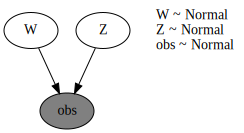

In [41]:
pyro.clear_param_store()


def ppca_model_without_plate_3(data, latent_dim):
    N, data_dim = data.shape
    W = pyro.sample(
        "W",
        dist.Normal(
            loc=torch.zeros([latent_dim, data_dim]),
            scale=5.0 * torch.ones([latent_dim, data_dim]),
        ).to_event(),
    )
    Z = pyro.sample(
        "Z",
        dist.Normal(
            loc=torch.zeros([N, latent_dim]),
            scale=torch.ones([N, latent_dim]),
        ).to_event(),
    )

    mean = Z @ W

    ob = pyro.distributions.Normal(mean, 1.0)
    return pyro.sample("obs", ob, obs=data)


pyro.render_model(
    ppca_model_without_plate_3, model_args=(X, 1), render_distributions=True
)

In [42]:
ag = create_guide_optimize_plot(ppca_model_without_plate_3)

******************** Error ********************

at site "obs", invalid log_prob shape
  Expected [], actual [200, 2]
  Try one of the following fixes:
  - enclose the batched tensor in a with pyro.plate(...): context
  - .to_event(...) the distribution being sampled
  - .permute() data dimensions

************************************************


Finally, we can create a to_event() on the ob variable as well

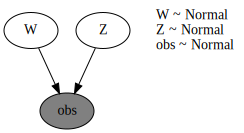

In [43]:
pyro.clear_param_store()


def ppca_model_without_plate_4(data, latent_dim):
    N, data_dim = data.shape
    W = pyro.sample(
        "W",
        dist.Normal(
            loc=torch.zeros([latent_dim, data_dim]),
            scale=5.0 * torch.ones([latent_dim, data_dim]),
        ).to_event(),
    )
    Z = pyro.sample(
        "Z",
        dist.Normal(
            loc=torch.zeros([N, latent_dim]),
            scale=torch.ones([N, latent_dim]),
        ).to_event(),
    )

    mean = Z @ W

    ob = pyro.distributions.Normal(mean, 1.0).to_event()
    return pyro.sample("obs", ob, obs=data)


pyro.render_model(
    ppca_model_without_plate_4, model_args=(X, 1), render_distributions=True
)

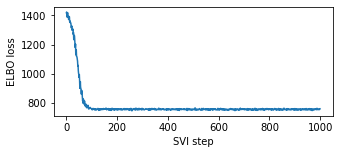

In [44]:
ag = create_guide_optimize_plot(ppca_model_without_plate_4)

Let us now try to create a predictive distribution.

In [45]:
trace = poutine.trace(ag).get_trace(X, 1)

In [46]:
predictive = pyro.infer.Predictive(ppca_model_without_plate_4, guide=ag, num_samples=1)

In [47]:
predictive

Predictive(
  (guide): AutoNormal(
    (locs): PyroModule()
    (scales): PyroModule()
  )
)

In [48]:
samples = predictive(X, 1)

In [49]:
samples['W'].shape

torch.Size([1, 1, 2])

In [50]:
samples['Z'].shape

torch.Size([1, 200, 1])

In [51]:
X_gen = samples['obs'][0, :, :]

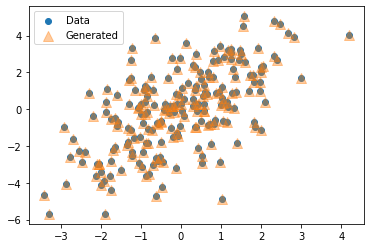

In [60]:
plt.scatter(X[:, 0], X[:, 1], label='Data')

plt.scatter(X_gen[:, 0], X_gen[:, 1], s = 100, alpha=0.4, marker='^', label='Generated')
plt.legend()

But, wait, now it seems we are getting exact same X? Why? As our model had: `return pyro.sample("obs", ob, obs=data)`. This will ensure we always return `data`. Let us now modify to set `data=None` to allow us to not use the observed data.

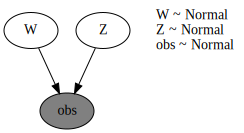

In [61]:
pyro.clear_param_store()


def ppca_model_without_plate_5(data  = None, latent_dim=1):
    N, data_dim = data.shape
    W = pyro.sample(
        "W",
        dist.Normal(
            loc=torch.zeros([latent_dim, data_dim]),
            scale=5.0 * torch.ones([latent_dim, data_dim]),
        ).to_event(),
    )
    Z = pyro.sample(
        "Z",
        dist.Normal(
            loc=torch.zeros([N, latent_dim]),
            scale=torch.ones([N, latent_dim]),
        ).to_event(),
    )

    mean = Z @ W

    ob = pyro.distributions.Normal(mean, 1.0).to_event()
    return pyro.sample("obs", ob, obs=data)


pyro.render_model(
    ppca_model_without_plate_5, model_args=(X, 1), render_distributions=True
)

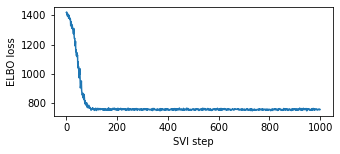

In [62]:
ag = create_guide_optimize_plot(ppca_model_without_plate_5)

In [63]:
predictive = pyro.infer.Predictive(ppca_model_without_plate_5, guide=ag, num_samples=1)

In [64]:
samples = predictive(None, 1)

AttributeError: 'NoneType' object has no attribute 'shape'

But, we were getting the N, data_dim from the data. In the absence of passing in the actual data, we may need to create additional arguments to our modelling function.

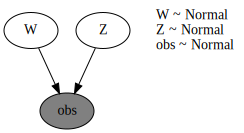

In [65]:
pyro.clear_param_store()


def ppca_model_without_plate_6(data  = None, latent_dim=1, N = 200, data_dim = 2):
    if data is not None:
        N, data_dim = data.shape
    W = pyro.sample(
        "W",
        dist.Normal(
            loc=torch.zeros([latent_dim, data_dim]),
            scale=5.0 * torch.ones([latent_dim, data_dim]),
        ).to_event(),
    )
    Z = pyro.sample(
        "Z",
        dist.Normal(
            loc=torch.zeros([N, latent_dim]),
            scale=torch.ones([N, latent_dim]),
        ).to_event(),
    )

    mean = Z @ W

    ob = pyro.distributions.Normal(mean, 1.0).to_event()
    return pyro.sample("obs", ob, obs=data)


pyro.render_model(
    ppca_model_without_plate_6, model_args=(X, 1), render_distributions=True
)

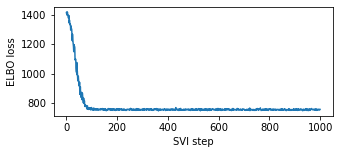

In [66]:
ag = create_guide_optimize_plot(ppca_model_without_plate_6)

In [70]:
num_samples = 100
predictive = pyro.infer.Predictive(ppca_model_without_plate_6, guide=ag, num_samples=num_samples)

In [68]:
samples = predictive(None, 1, 200, 2)

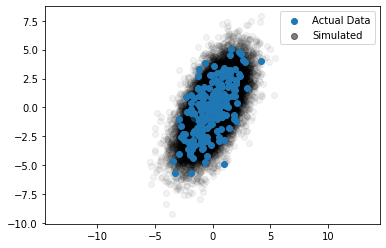

In [73]:
for i in range(num_samples-1):
    X_gen = samples['obs'][i, :, :]
    plt.scatter(X_gen[:, 0], X_gen[:, 1], color='k', alpha=0.05)
plt.scatter(X[:, 0], X[:, 1], label='Actual Data')
plt.axis('equal')
plt.scatter(X_gen[num_samples, 0], X_gen[num_samples, 1], color='k', alpha=0.5, label='Simulated')
plt.legend()

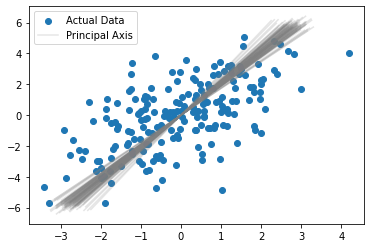

In [79]:
for W_sample in samples['W']:
    z_lin_w = z_lin@W_sample
    plt.plot(z_lin_w[:, 0], z_lin_w[:, 1], color='gray', alpha=0.2)
plt.scatter(X[:, 0], X[:, 1], label='Actual Data')
plt.plot(z_lin_w[:, 0], z_lin_w[:, 1], color='gray', alpha=0.2, label='Principal Axis Samples')
plt.legend()

### With plate notation

Now, we will be using the Plate notation to create the same model.

We would like the following shapes in our model

W ∈ R^(d X D)
zn ∈ R^d
mean ∈ R^D

In [105]:
pyro.clear_param_store()


def ppca_model_plate(data, latent_dim):
    N, data_dim = data.shape
    W = pyro.sample(
        "W",
        dist.Normal(
            loc=torch.zeros([latent_dim, data_dim]),
            scale=5.0 * torch.ones([latent_dim, data_dim]),
        ).to_event(),
    )
    
    with pyro.plate("data", N):
        
        zn = pyro.sample("zn", dist.Normal(torch.zeros([latent_dim]), 1.))
        mean = torch.matmul(W.t(), zn)
        return pyro.sample("obs", dist.Normal(mean, 1.), obs=data)
    
    
try:
    pyro.render_model(
        ppca_model_plate, model_args=(X, 1), render_distributions=True
    )
except Exception as e:
    print("*"*20+" Error "+"*"*20+"\n")
    print(e)
    print("\n"+"*"*48)
    

******************** Error ********************

size mismatch, got 2, 2x1,200
Trace Shapes:          
 Param Sites:          
Sample Sites:          
       W dist     | 1 2
        value     | 1 2
    data dist     |    
        value 200 |    
      zn dist 200 |    
        value 200 |    

************************************************


Wait! zn seems to be of size 200? Ah! The size of the data! Let us as before move the code outside the context of the `model` and understand things better.

In [122]:
with pyro.plate("data", N):
    zn = pyro.sample("zn", dist.Normal(torch.zeros([latent_dim]), 1.))

In [123]:
zn.shape

torch.Size([200])

In [125]:
with pyro.plate("data", N):
    zn = pyro.sample("zn", dist.Normal(torch.zeros([1, latent_dim]), 1.))
zn.shape

torch.Size([1, 200])

In [137]:
pyro.clear_param_store()


def ppca_model_plate_1(data, latent_dim):
    N, data_dim = data.shape
    W = pyro.sample(
        "W",
        dist.Normal(
            loc=torch.zeros([latent_dim, data_dim]),
            scale=5.0 * torch.ones([latent_dim, data_dim]),
        ).to_event(),
    )
    
    with pyro.plate("data", N):
        
        Z = pyro.sample("Z", dist.Normal(torch.zeros([latent_dim]), torch.ones([latent_dim])).to_event())
       
        mean = Z@W
        return pyro.sample("obs", dist.Normal(mean, 1.).to_event(), obs=data)
    
    
try:
    pyro.render_model(
        ppca_model_plate_1, model_args=(X, 1), render_distributions=True
    )
except Exception as e:
    print("*"*20+" Error "+"*"*20+"\n")
    print(e)
    print("\n"+"*"*48)

<p style="background-color:Tomato;">Why do we need a `.to_event()` here? Could not figure out, had to do a lot of hit and trial.
</p>

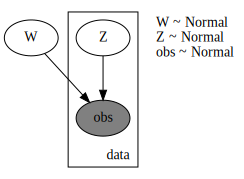

In [138]:
pyro.render_model(
        ppca_model_plate_1, model_args=(X, 1), render_distributions=True
    )

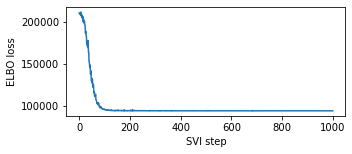

In [139]:
ag = create_guide_optimize_plot(ppca_model_plate_1)

Wait, the ELBO loss looks so much higher than the previous case?! 

<p style="background-color:Tomato;">Why is the ELBO loss so high here in plate model compared to non-plate model?</p>